In [1]:
import sys, os
sys.path.append('..')
sys.path.append('.')

import yaml

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

#import wandb
#resume = False
#wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

# Imports for regnet
# import math
# import os
# import random
# import shutil
# import time

# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from Recorder import Recorder
# from data_utils import RegnetLoader, get_TSN_Data_set
# from criterion import RegnetLoss
# from model import Regnet, Modal_Response_Net
# # from test import test_checkpoint
# from contextlib import redirect_stdout
# from config import _C as config
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from tqdm import tqdm

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 20
plt.rcParams['font.size'] = font_size

fig_width = 6
fig_height = 4
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    print('audio shape: ', audio.shape)
    if len(audio.shape) == 2:
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    #print(np.max(logmag))
    f, t, Zxx = scipy.signal.stft(audio, train_sample_rate, nperseg=size, noverlap=int(0.75*size))
    # logmag = spectral_ops.compute_logmel(core.tf_float32(audio), lo_hz=8.0, bins=80, fft_size=size)
    # logmag = spectral_ops.compute_mfcc(core.tf_float32(audio), mfcc_bins=40, fft_size=size)
    if rotate:
        # logmag = np.rot90(np.log(np.abs(Zxx)))
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(test_samples) / train_sample_rate
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, example_secs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    #xtick_locs = (xtick_nums / example_secs * logmag.shape[1]).astype(np.int32)
    #xtick_nums = xtick_locs / logmag.shape[1] * example_secs
    #plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # plt.yticks([])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

In [3]:
# Eval with saved tensors
def generate_audio_testing(raw_gain, raw_freq, raw_dampings, modal_fir, reverb, impulse_profile,
                           gains, frequencies, dampings, modal_response,
                           noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls'):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D?
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    zero_freq = np.zeros_like(raw_freq)
    zero_gain = np.random.rand(1,256) #np.zeros_like(raw_gain)
    zero_damp = np.zeros_like(raw_dampings)
    
#     vid = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-10-of-47'
#     raw_gain = np.load(os.path.join(freq_path, vid+"_gains_raw.npy"))
#     raw_freq = np.load(os.path.join(freq_path, vid+"_freqs_raw.npy"))
#     raw_dampings = np.load(os.path.join(freq_path, vid+"_dampings_raw.npy"))
    
    # Get modal response from raw freqs, gains, and dampings
    irc_scratch = modal_fir.get_controls(raw_gain, raw_freq, raw_dampings)
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    
    # Get modal response from scaled (passed through get_controls) freqs, gains, dampings
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    print("ir: ", ir)
    print("model's output modal response: ", modal_response)
    #print("ir_scratch: ", ir_scratch)
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls' or scratch =='control':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)),
    #minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

In [4]:
# Use this method!!!!!
def generate_audio(predictions, modal_fir, reverb, impulse_profile, gains, frequencies, dampings, modal_response,
                   noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls',
                   modal_fir_only=True):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR --> modal response (object material sound)
    # TODO: To use "raw" normally again, make sure to switch this!!
    irc_scratch = modal_fir.get_controls(predictions['gains'], predictions['frequencies'], predictions['dampings'])
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    # Plotting the network output modal response
    print("Plotting convolve generated modal response")
    output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/modal_fir'
    os.makedirs(output_dir, exist_ok=True)
    begin_offset = int(train_sample_rate * 1.95)
    cutoff = int(train_sample_rate * 2.5)

    ir_plot = np.squeeze(ir_scratch) # modal response
    print(ir_plot.shape)
    ir_plot = ir_plot[begin_offset:cutoff]
    t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
    plt.plot(t2, ir_plot)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    fig = plt.gcf()
    fig.set_size_inches(fig_width+2, fig_height)
    if no_axis:
        ax = plt.gca()
        # ax.axes.yaxis.set_visible(False)
#         ax.axes.yaxis.set_ticks([])
        plt.xticks(fontsize=font_size-6)
    fig.savefig(os.path.join(output_dir, audio_title+f'_convolve_ir-material_id_{material_id}.png'), bbox_inches='tight')
    plt.show()

    print("model's output modal response: ", modal_response)
    print("ir_scratch: ", ir_scratch)
    print("ir: ", ir)
    
    check = tf.math.equal(modal_response, ir_scratch)
    print(f"compared elements of modal response: {check}")
    assert(tf.reduce_all(check) == True)
    print(f"element-wise comparison of network output modal response and from scratch: {tf.reduce_all(check)}")
    
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    if modal_fir_only:
        print("Return audio without adding noise, acceleration sound, or reverb")
        audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
        return audio
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

Latest operative config used:  /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/operative_config-0.gin
n modal frequencies: 256
-4
4.0
/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/*/val/*.wav
Z time steps: 2520
Input key to EmbeddingContextEncoder: material_id
Output key to EmbeddingContextEncoder: material_embedding


INFO:absl:Loaded checkpoint /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (441344, 1)
(1, 441000)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 441000), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


Plotting original waveform


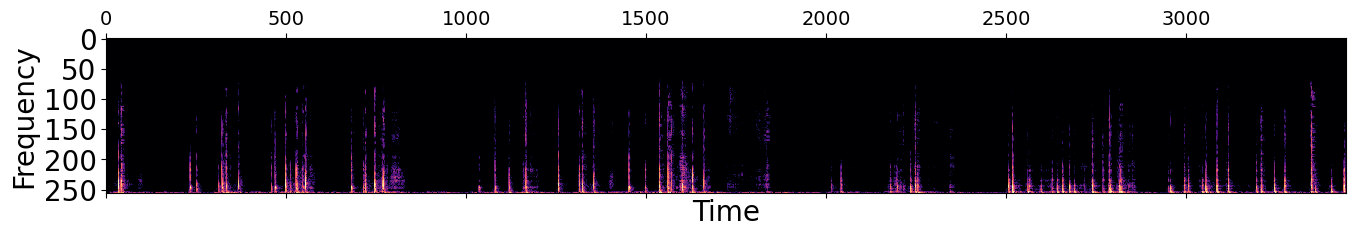

number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 441000)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[1.55984168e-03 2.03807373e-03 1.71299744e-03 ... 2.43409653e-04
   1.83036696e-04 3.40800034e-06]
  [2.14347476e-03 2.11963709e-03 6.74147671e-03 ... 2.11437859e-04
   1.67058475e-04 1.61459786e-04]
  [8.27587768e-03 5.09157684e-03 7.58522423e-03 ... 8.99397346e-05
   6.35841716e-05 1.09406654e-04]
  ...
  [2.16140008e+00 2.85483265e+00 3.68525362e+00 ... 2.11738725e-03
   2.22423044e-03 1.94764137e-03]
  [1.57971537e+00 1.61101878e+00 1.60835969e+00 ... 2.63001653e-03
   2.61310907e-03 2.59411335e-03]
  [1.56003330e-02 2.55000275e-02 4.15077582e-02 ... 6.86831132e-04
   6.87345164e-04 6.87545165e-04]]], shape=(1, 1723, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.00000000e+00 1.62990496e-03 4.08168766e-04 ... 1.12845469e-03
   1.

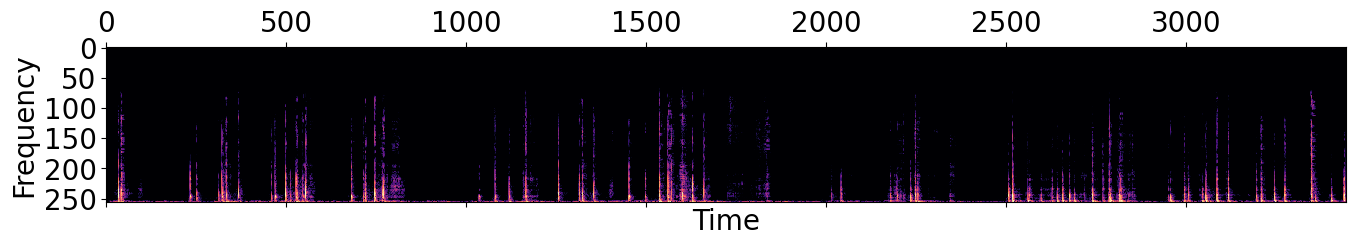

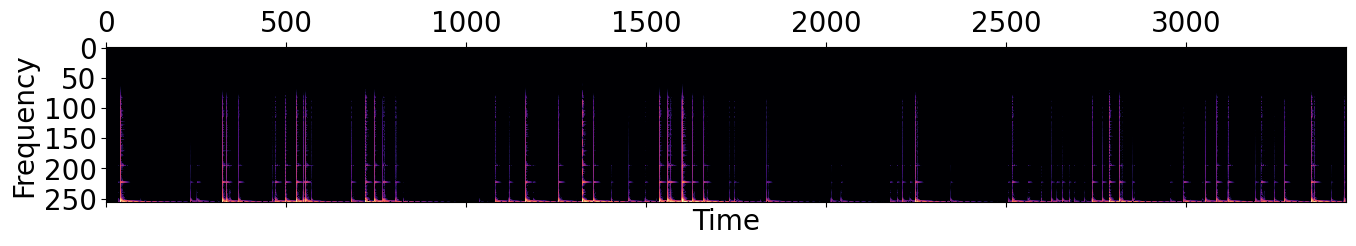

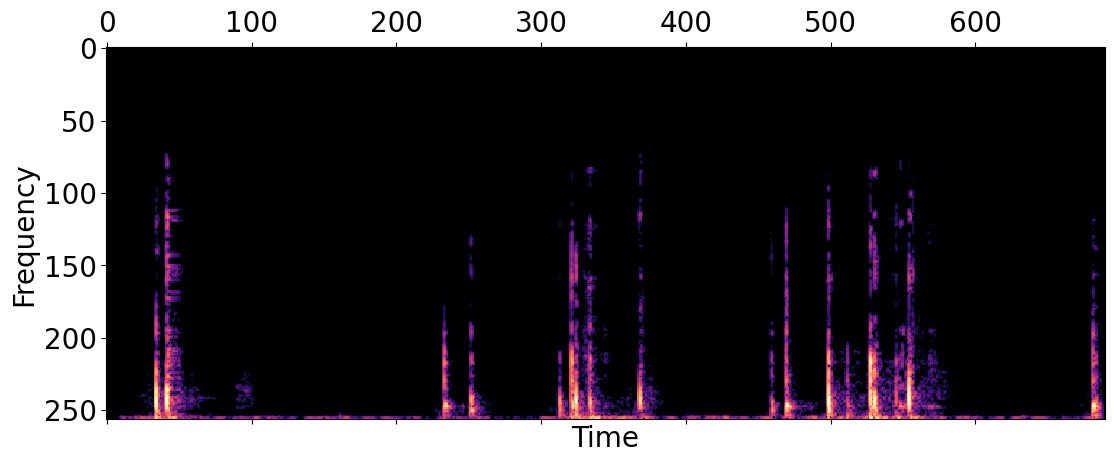

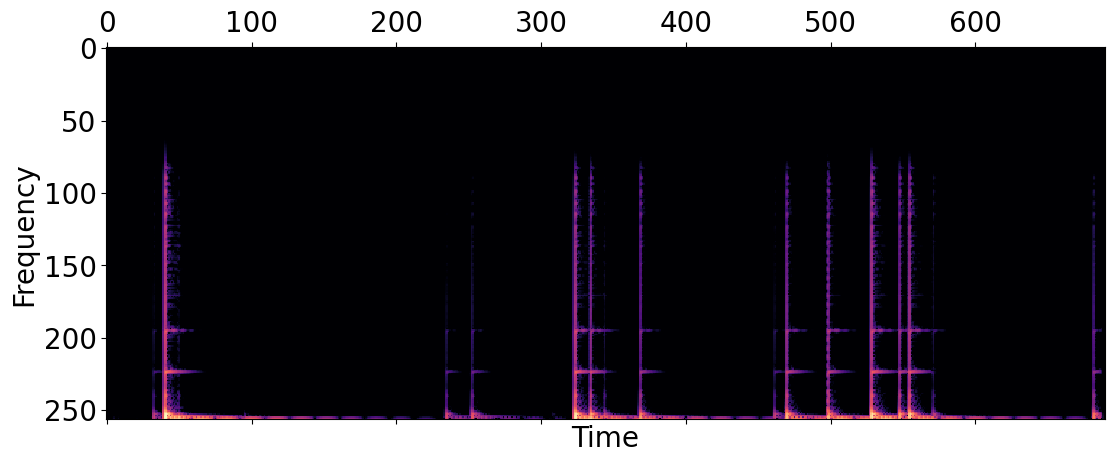

Output synth of the checkpoint from prediction[audio_synth]


Plotting impulse profile


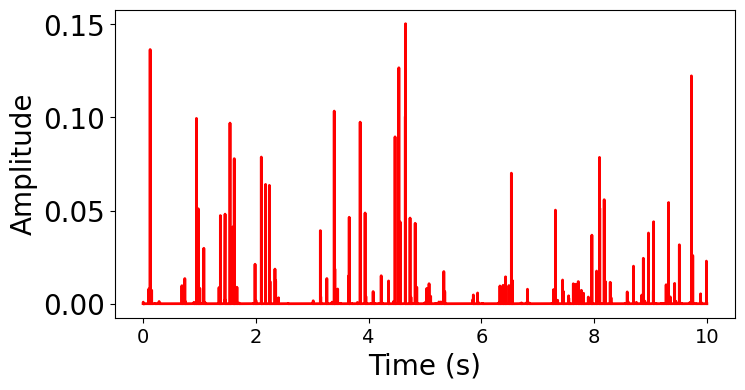

Plotting network output modal response
(176400,)


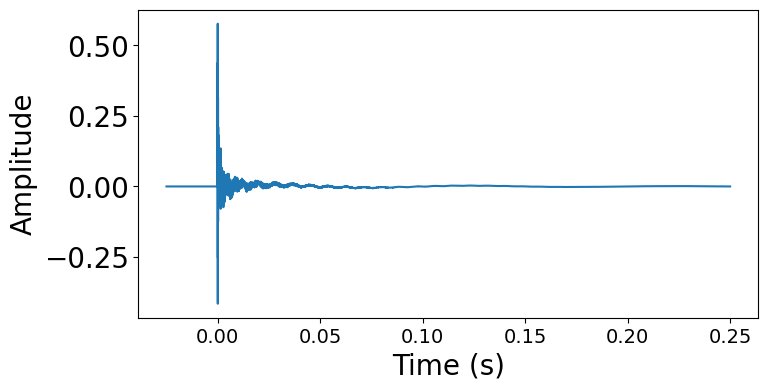

input shapes! impulse_profile: (1, 882000), ir: (1, 176400), noise: (1, 882000), revc: (1, 48000)
impulse profile shape:  (1, 882000)
Size of frequency envelope:  (1, 1, 256)
size of amplitude envelop:  (1, 256)
Size of frequency envelope:  (1, 88200, 256)
size of amplitude envelop:  (1, 88200, 256)
Size of frequency envelope:  (1, 88200, 256)
size of amplitude envelop:  (1, 88200, 256)
Plotting convolve generated modal response
(176400,)


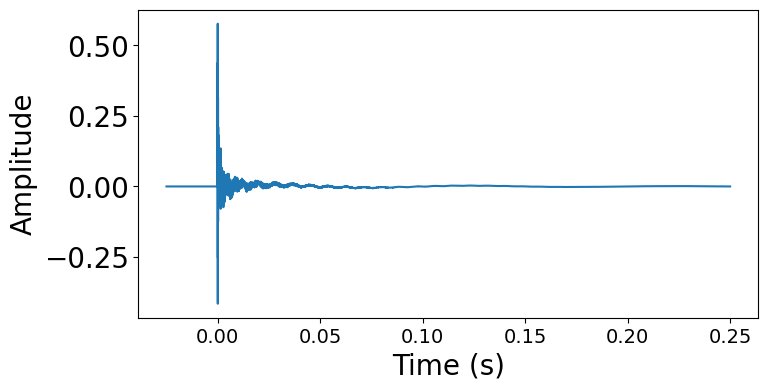

model's output modal response:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.9953646e-07
  2.0174355e-07 2.0395032e-07]], shape=(1, 176400), dtype=float32)
ir_scratch:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.9953646e-07
  2.0174355e-07 2.0395032e-07]], shape=(1, 176400), dtype=float32)
ir:  tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.9953646e-07
  2.0174355e-07 2.0395032e-07]], shape=(1, 176400), dtype=float32)
compared elements of modal response: [[ True  True  True ...  True  True  True]]
element-wise comparison of network output modal response and from scratch: True
impulse response shape:  [1, 1, 176400]
audio_frames shape:  (1, 1, 882000)
n_audio_frames: 1 and n_ir_frames: 1
convolved shape:  (1, 882000)
after adding noise:  (1, 882000)
after acceleration sound:  (1, 882000)
impulse response shape:  [1, 1, 48000]
audio_frames shape:  (1, 1, 882000)
n_audio_frames: 1 and n_ir_frames: 1
after reverb:  (1, 882000)
audio sample ra

audio element-wise check:  tf.Tensor(True, shape=(), dtype=bool)
network audio synth: [[-2.7605242e-06 -1.1501870e-06  4.6840310e-06 ... -5.1672326e-04
  -4.6236426e-04 -6.6095497e-04]]
convolve output: [[-2.7604308e-06 -1.1499499e-06  4.6843106e-06 ... -5.1555195e-04
  -4.6211242e-04 -6.6198292e-04]]
differences: [[-9.3450581e-11 -2.3715074e-10 -2.7966962e-10 ... -1.1713128e-06
  -2.5183544e-07  1.0279473e-06]]
average of the differences:  tf.Tensor(5.3497486e-05, shape=(), dtype=float32)
Plotting audio synth waveform


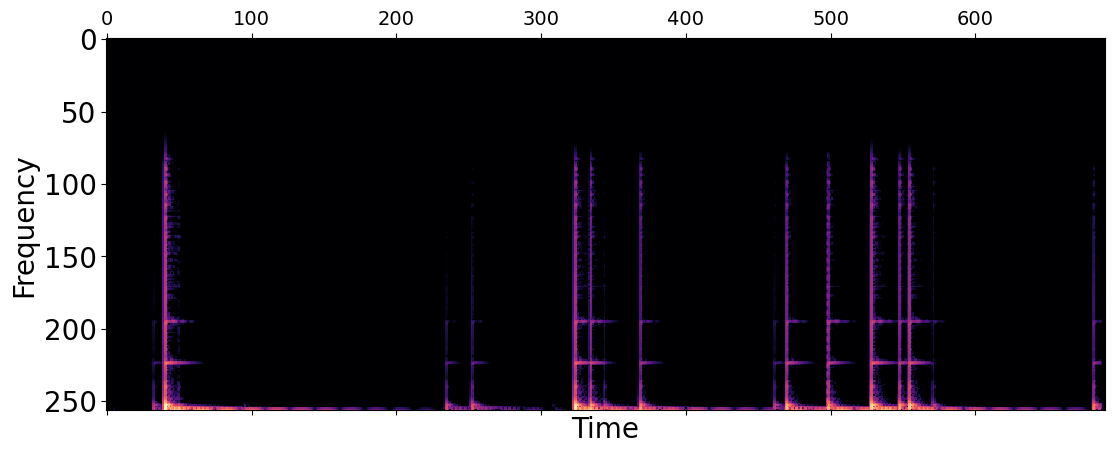

Plotting convolve waveform


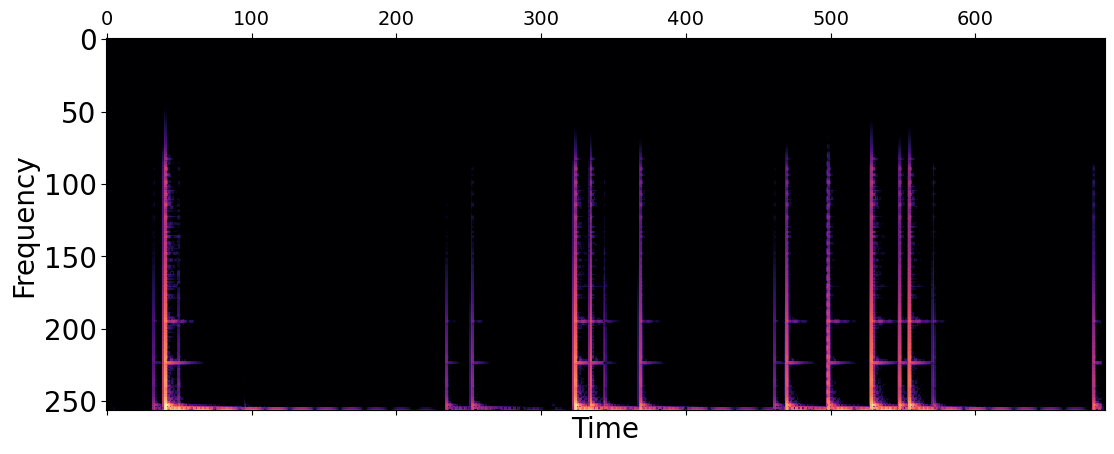

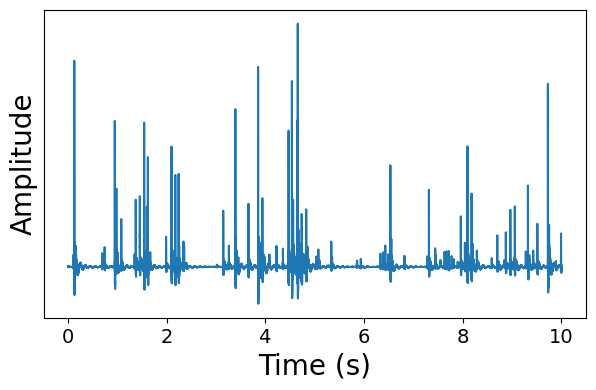

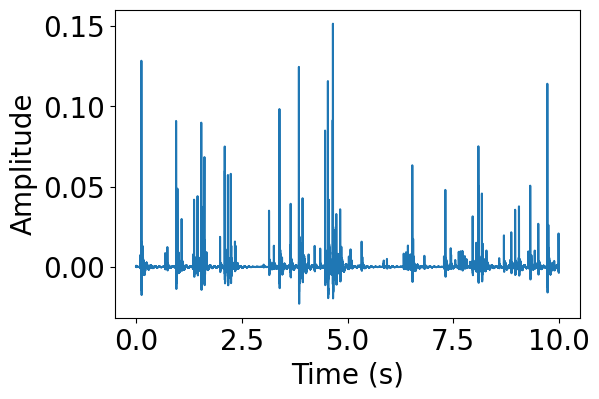

mags shape: (1, 2520, 1)
stdevs shape: (1, 2520, 1)
taus shape: (1, 2520, 1)


In [5]:
# Test out the N_MODAL_FREQUENCIES=256 checkpoint for multiclass checkpoint
from IPython.display import display
no_axis = True

# Path to eval output
#eval_output = "/juno/u/jyau/regnet/ckpt/visual_extract_pipeline_rgb_only/checkpoint_075000/eval_output"
# Full pipeline
voc_type = "wood-box" #"silicone-pad" #"wooden-box" # wood-box
vocoder_type = 'wooden-box'
save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/'
# save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/1hr-{vocoder_type}'
# save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{voc_type}' # Sam's checkpoint
# save_dir = '/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/train-all'
example_secs = 10
offset_secs = 0

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
print(f"n modal frequencies: {n_modal_freq}")
#gin.config.bind_parameter('%N_MODAL_FREQUENCIES', 64)
#n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
#print(f"n modal frequencies: {n_modal_freq}")

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

audio_sample_rate = train_sample_rate

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

model = ddsp.training.models.get_model()
model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0

# audio_title = vid
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-silicon-coaster-29-of-48'
# audio_title = "ASMR_Brain_Penetrating_3D_Tapping_No_Talking-101-of-240"
# audio_title = "compilation_final"
#audio_title = "The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-plastic-mold-2-16-of-18"
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-34-of-47'
audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-wooden-box-42-of-45"
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
#audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
try:
#     audio = tf.io.read_file(f'/juno/u/jyau/regnet/ckpt/regnet_baseline_asmr_by_material/val_inf_last_ckpt_waveglow_trainall/{audio_title}_synthesis.wav')
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/train/{audio_title}.wav')
except Exception as ex:
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/val/{audio_title}.wav')
# audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/ASMR_Brain_3D_Tapping/audio_10s_44100hz/{audio_title}.wav')
#compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
#orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio_init, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio_init.shape)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio_init[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)

material_id = 5
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[material_id], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(train_sample_rate)))

# Plotting audio waveforms
print("Plotting original waveform")
output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/'
# plot_spec(decoded_audio, 512)
ddsp.colab.colab_utils.specplot(decoded_audio, size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+'_orig_audio.png'), bbox_inches='tight')
plt.show()

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print(f"prediction keys: {prediction.keys()}")
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()

print("Output synth of the checkpoint from prediction[audio_synth]")
display(IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(train_sample_rate)))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

# Generate audio by replacing the frequency with eval
#samplerate, data = wavfile.read(wav_fname)
# print(f"number of channels = {data.shape[1]}")
# number of channels = 2
# length = data.shape[0] / samplerate
# print(f"length = {length}s")
# length = 0.01s

# modal_fir = ddsp.synths.ModalFIR(n_samples=int(fs*sample_factor/1.0), sample_rate=int(fs*sample_factor),
#                             initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
# Note that clip is the data in example above, so clip.shape[0] is the length of the audio: seconds * sample rate
# impact = ddsp.synths.Impact(sample_rate=int(fs*sample_factor), n_samples=int(clip.shape[0]*sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
# reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)
# Initialize modules
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_sample_rate), sample_rate=int(sample_factor * train_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate), n_samples=int(sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))

# Plotting impact/force profile
print("Plotting impulse profile")
output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/impact_profile_noaxis'
os.makedirs(output_dir, exist_ok=True)

t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red', linewidth=2)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
    
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
fig.savefig(os.path.join(output_dir, audio_title+f'_impact_signal_only-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Plotting the network output modal response
print("Plotting network output modal response")
output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/modal_fir'
os.makedirs(output_dir, exist_ok=True)
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir_plot = np.squeeze(prediction['modal_fir']['signal']) # modal response
print(ir_plot.shape)
ir_plot = ir_plot[begin_offset:cutoff]
t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir_plot)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_ir-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")

audio_final = generate_audio(prediction, modal_fir, reverb, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw',
                             modal_fir_only=False)

print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

test_audio = tf.math.equal(prediction['audio_synth'], audio_final)
print("audio element-wise check: ", tf.reduce_any(test_audio))

if not tf.reduce_all(tf.math.equal(prediction['audio_synth'], audio_final)):
    print(f"network audio synth: {prediction['audio_synth']}")
    print(f"convolve output: {audio_final}")
    print(f"differences: {prediction['audio_synth'] - audio_final}")
    print('average of the differences: ', tf.math.reduce_mean(prediction['audio_synth'] - audio_final))

# Plotting audio waveforms
print("Plotting audio synth waveform")
output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/final_audio'
# plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_synth_wav-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Plotting audio waveforms
print("Plotting convolve waveform")
# plot_spec(audio_final[:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(audio_final[:1, :train_sample_rate*2], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_convolve_wav-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()


output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/final_audio'
os.makedirs(output_dir, exist_ok=True)

plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+1, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_waveform-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()
plt.rcParams.update({
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),
})
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, audio_title+f'_waveform_translucent-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Check shape of the impact info
print(f"mags shape: {prediction['magnitudes'].shape}")
print(f"stdevs shape: {prediction['stdevs'].shape}")
print(f"taus shape: {prediction['taus'].shape}")

In [6]:
# Get modal response with the audio dspy library
# import audio_dspy as adsp
# mel = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/melspec_10s_44100hz/{vid}_mel.npy')
# print(f'mel shape: {mel.shape} and audio sample rate: {audio_sample_rate}')
# freqs, gains = adsp.find_freqs(decoded_audio_init, audio_sample_rate, plot=True)

# obj = {}
# obj['frequencies'] = freqs
# obj['gains'] = gains
# obj['dampings'] = prediction['dampings']

# # Generate modal response, and convolve with the force profile, noise, and reverb
# print(f"freqs: {freqs.shape}, gains: {gains.shape}, damping: {prediction['dampings'].shape} noise: {noise.shape}, revc: {revc.shape}")
# audio_final = generate_audio(obj, modal_fir, reverb, impulse_profile,
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw')
# print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
# display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

In [7]:
# scratch = 'else'
# # Generate modal FIR --> modal response (object material sound)
# modal_response = prediction['modal_fir']['signal']
# irc_scratch = modal_fir.get_controls(prediction['gains'], prediction['frequencies'], prediction['dampings'])
# ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
# #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
# ir = modal_fir.get_signal(prediction['modal_fir']['controls']['gains'],
#                           prediction['modal_fir']['controls']['frequencies'],
#                           prediction['modal_fir']['controls']['dampings'])
# print("ir: ", ir)
# print("model's output modal response: ", modal_response)
# print("ir_scratch: ", ir_scratch)
# # Convolve together for modal vibration sounds
# # Convolve together for modal vibration sounds
# if scratch == 'raw':
#     audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
# elif scratch == 'controls':
#     audio = ddsp.core.fft_convolve(impulse_profile, ir)
# else:
#     audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
# print("convolved shape: ", audio.shape)

# # Generate and add time constant noise
# audio += noise
# print("after adding noise: ", audio.shape)

# # Add acceleration sound
# audio += impulse_profile * acceleration_scale
# print("after acceleration sound: ", audio.shape)

# # Add reverb
# audio = reverb.get_signal(audio, revc)#revc['ir'])
# print("after reverb: ", audio.shape)

# # Downsample from internal sampling rate to original recording sampling rate
# print("audio sample rate: ", audio_sample_rate)
# audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
# display(IPython.display.Audio(data=audio, rate=int(train_sample_rate)))

In [8]:
# TODO: only after merging the regnet and ddsp models, otherwise they're using two different envs currently
# Load the trained frequency decoder model
# model = Modal_Response_Net()
# print("Initialized model")

# model.load_checkpoint(config.checkpoint_path)

# # Load data
# print("Getting the images to be stacked...")
# args.test_list = './filelists/asmr_by_material_1hr_train.txt' 
# trainset = get_TSN_Data_set(args)
# args.test_list = './filelists/asmr_by_material_1hr_test.txt'
# valset = get_TSN_Data_set(args)

# train_loader = DataLoader(trainset, num_workers=0, shuffle=True,
#                           batch_size=config.batch_size, pin_memory=False,
#                           drop_last=True)
# test_loader = DataLoader(valset, num_workers=0, shuffle=False,
#                          batch_size=config.batch_size, pin_memory=False)
# print("Check number of train examples: ", len(trainset))
# print("Check number of train loader examples: ", len(train_loader))
# assert(len(trainset) > 0)
# assert(len(train_loader) > 0)

In [9]:
# SpecGAN Vladimir evaluated sample check
# mel_check = np.load('/juno/u/jyau/SpecVQGAN/logs/2021-12-11T17-05-22_asmr_by_material_transformer/samples_None/VAS_validation/cls_1/ASMR_Addictive_Tapping_1_Hr_No_Talking-ceramic-plate-38-of-41_mel_sample_0.npy')
# print(mel_check.shape)
# ddsp.colab.colab_utils.specplot(mel_check, size=512)

# plt.figure()
# plt.imshow(mel_check,aspect='auto', origin='lower')
# plt.show()
#display(IPython.display.Audio(data=check, rate=int(44100)))